## Metrics

汇总常见2分类的指标，例如: AUC，ROC曲线，ACC, 敏感性， 特异性，精确度，召回率，PPV, NPV, F1

具体的介绍，可以参考一下：https://blog.csdn.net/sunflower_sara/article/details/81214897

In [1]:
import pandas as pd

# group = pd.read_csv('group.csv', dtype={'ID':str})

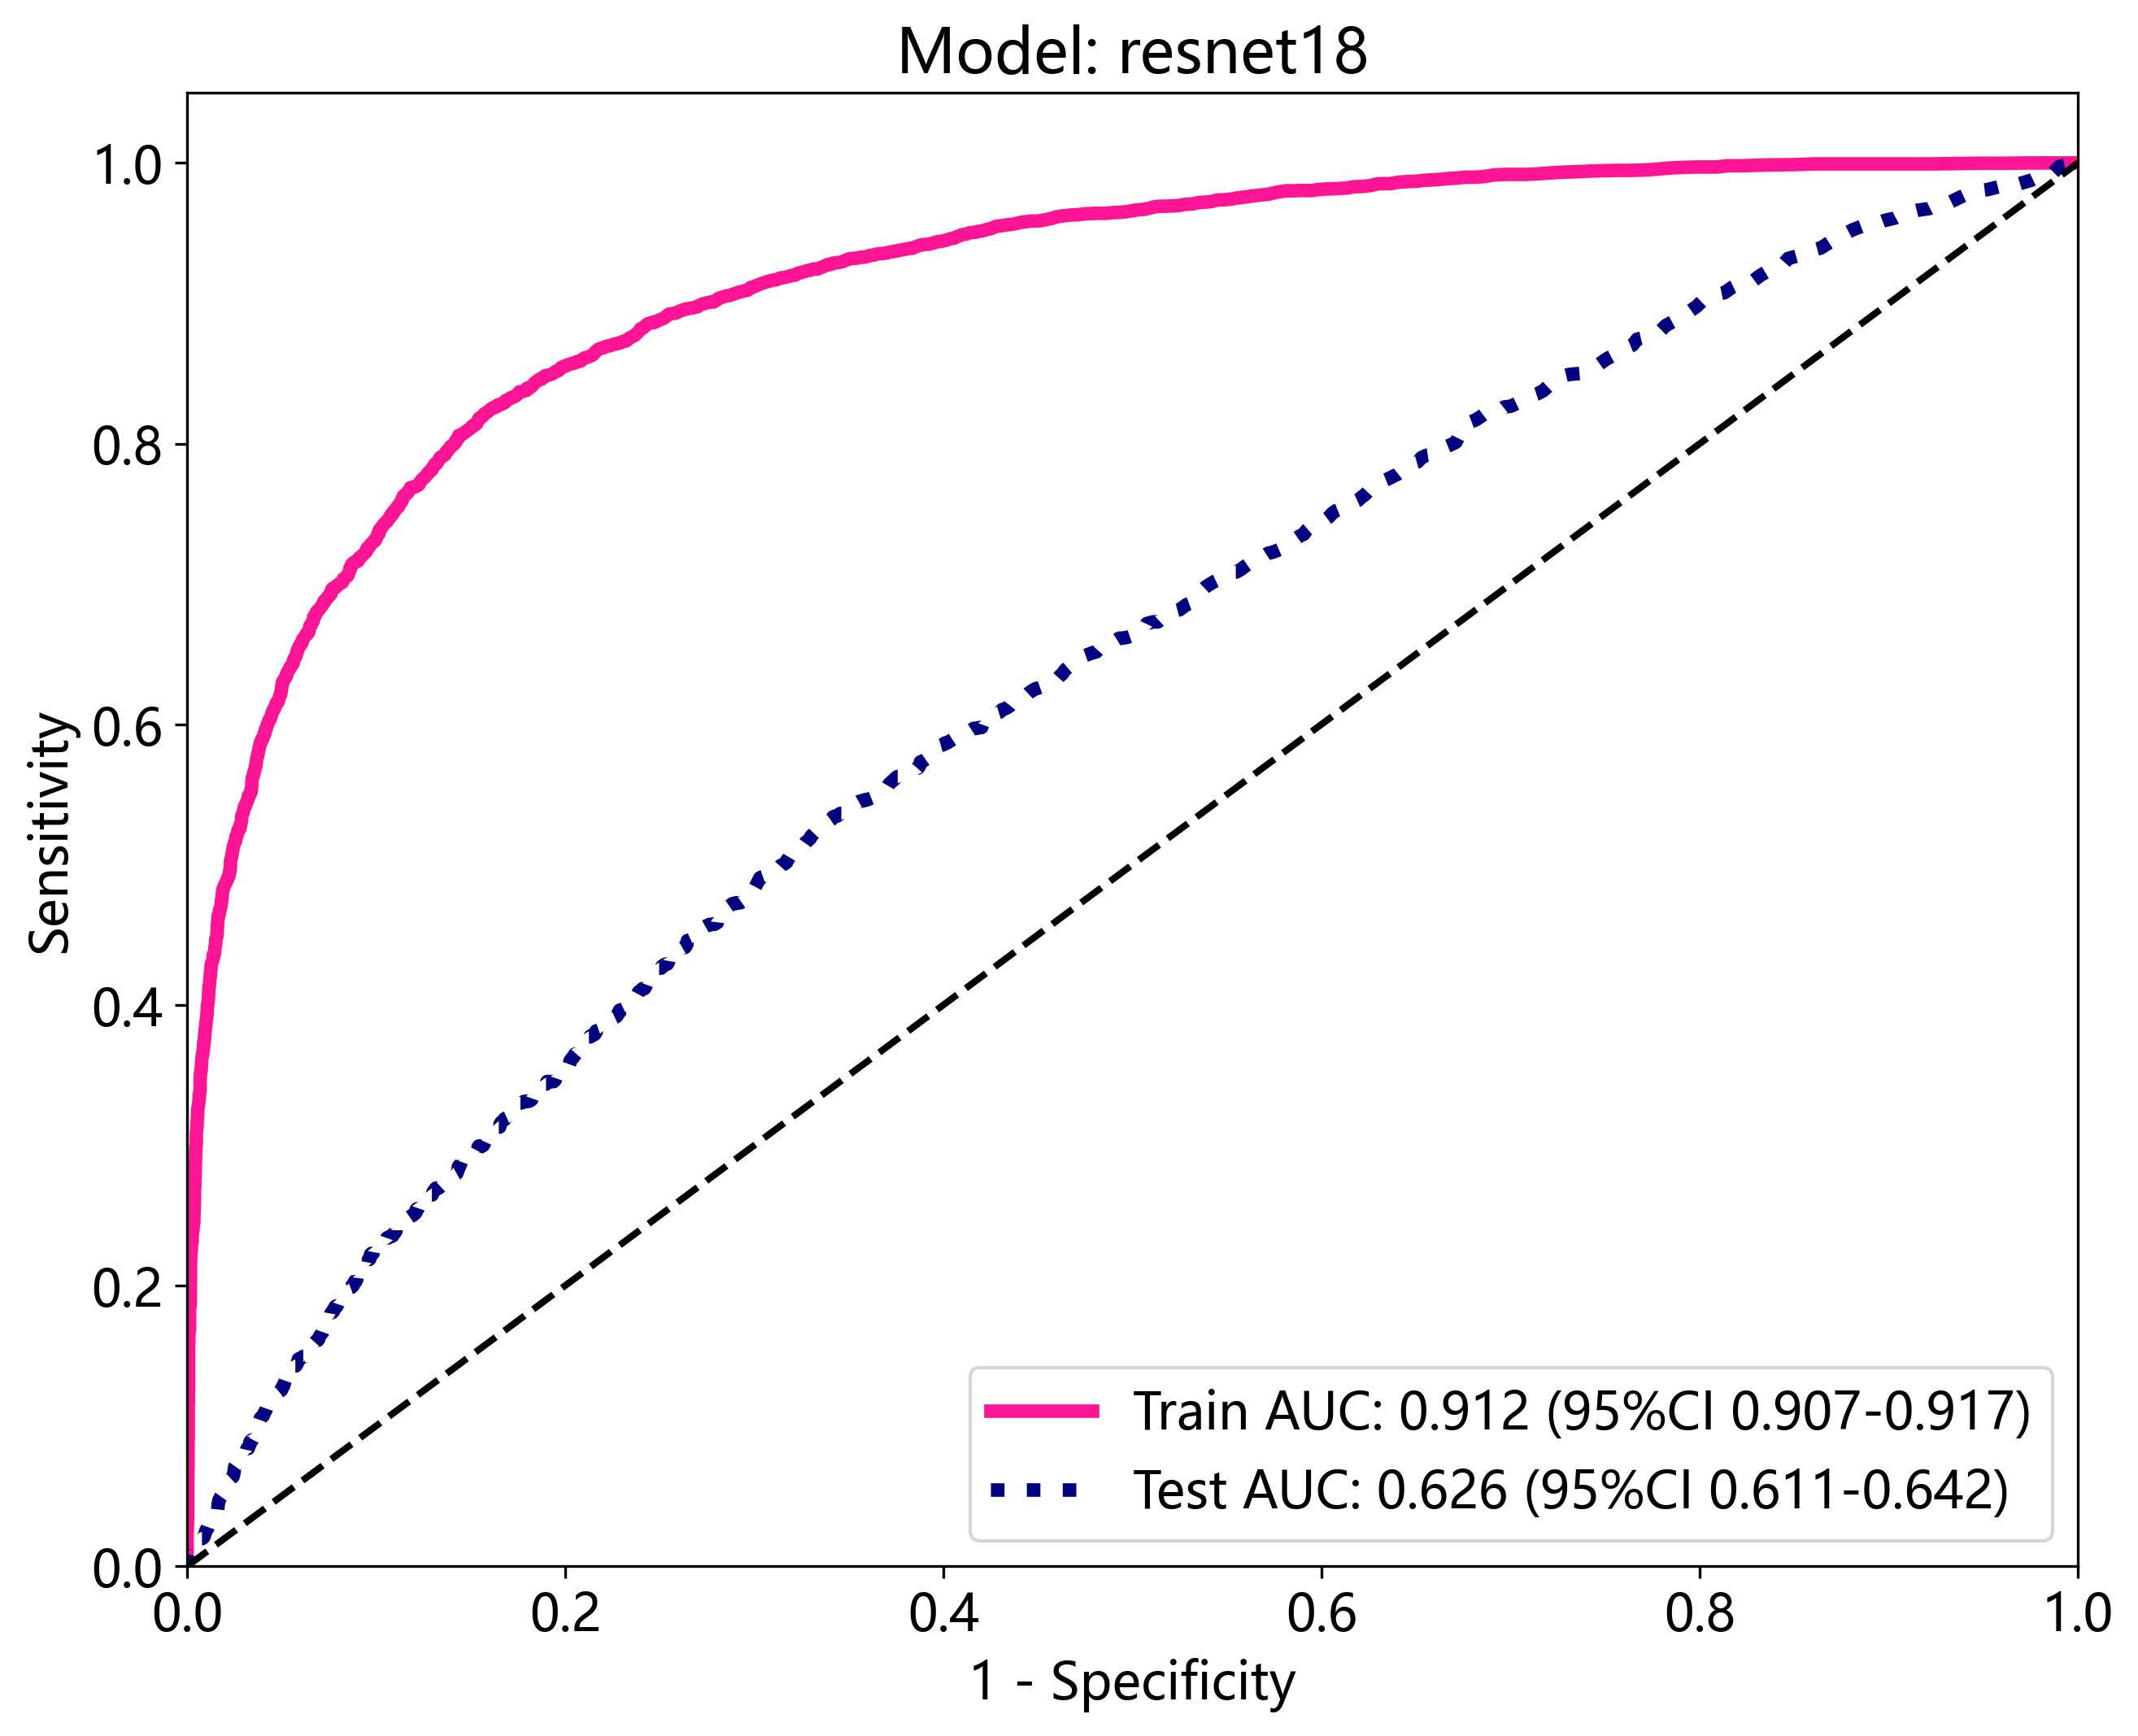

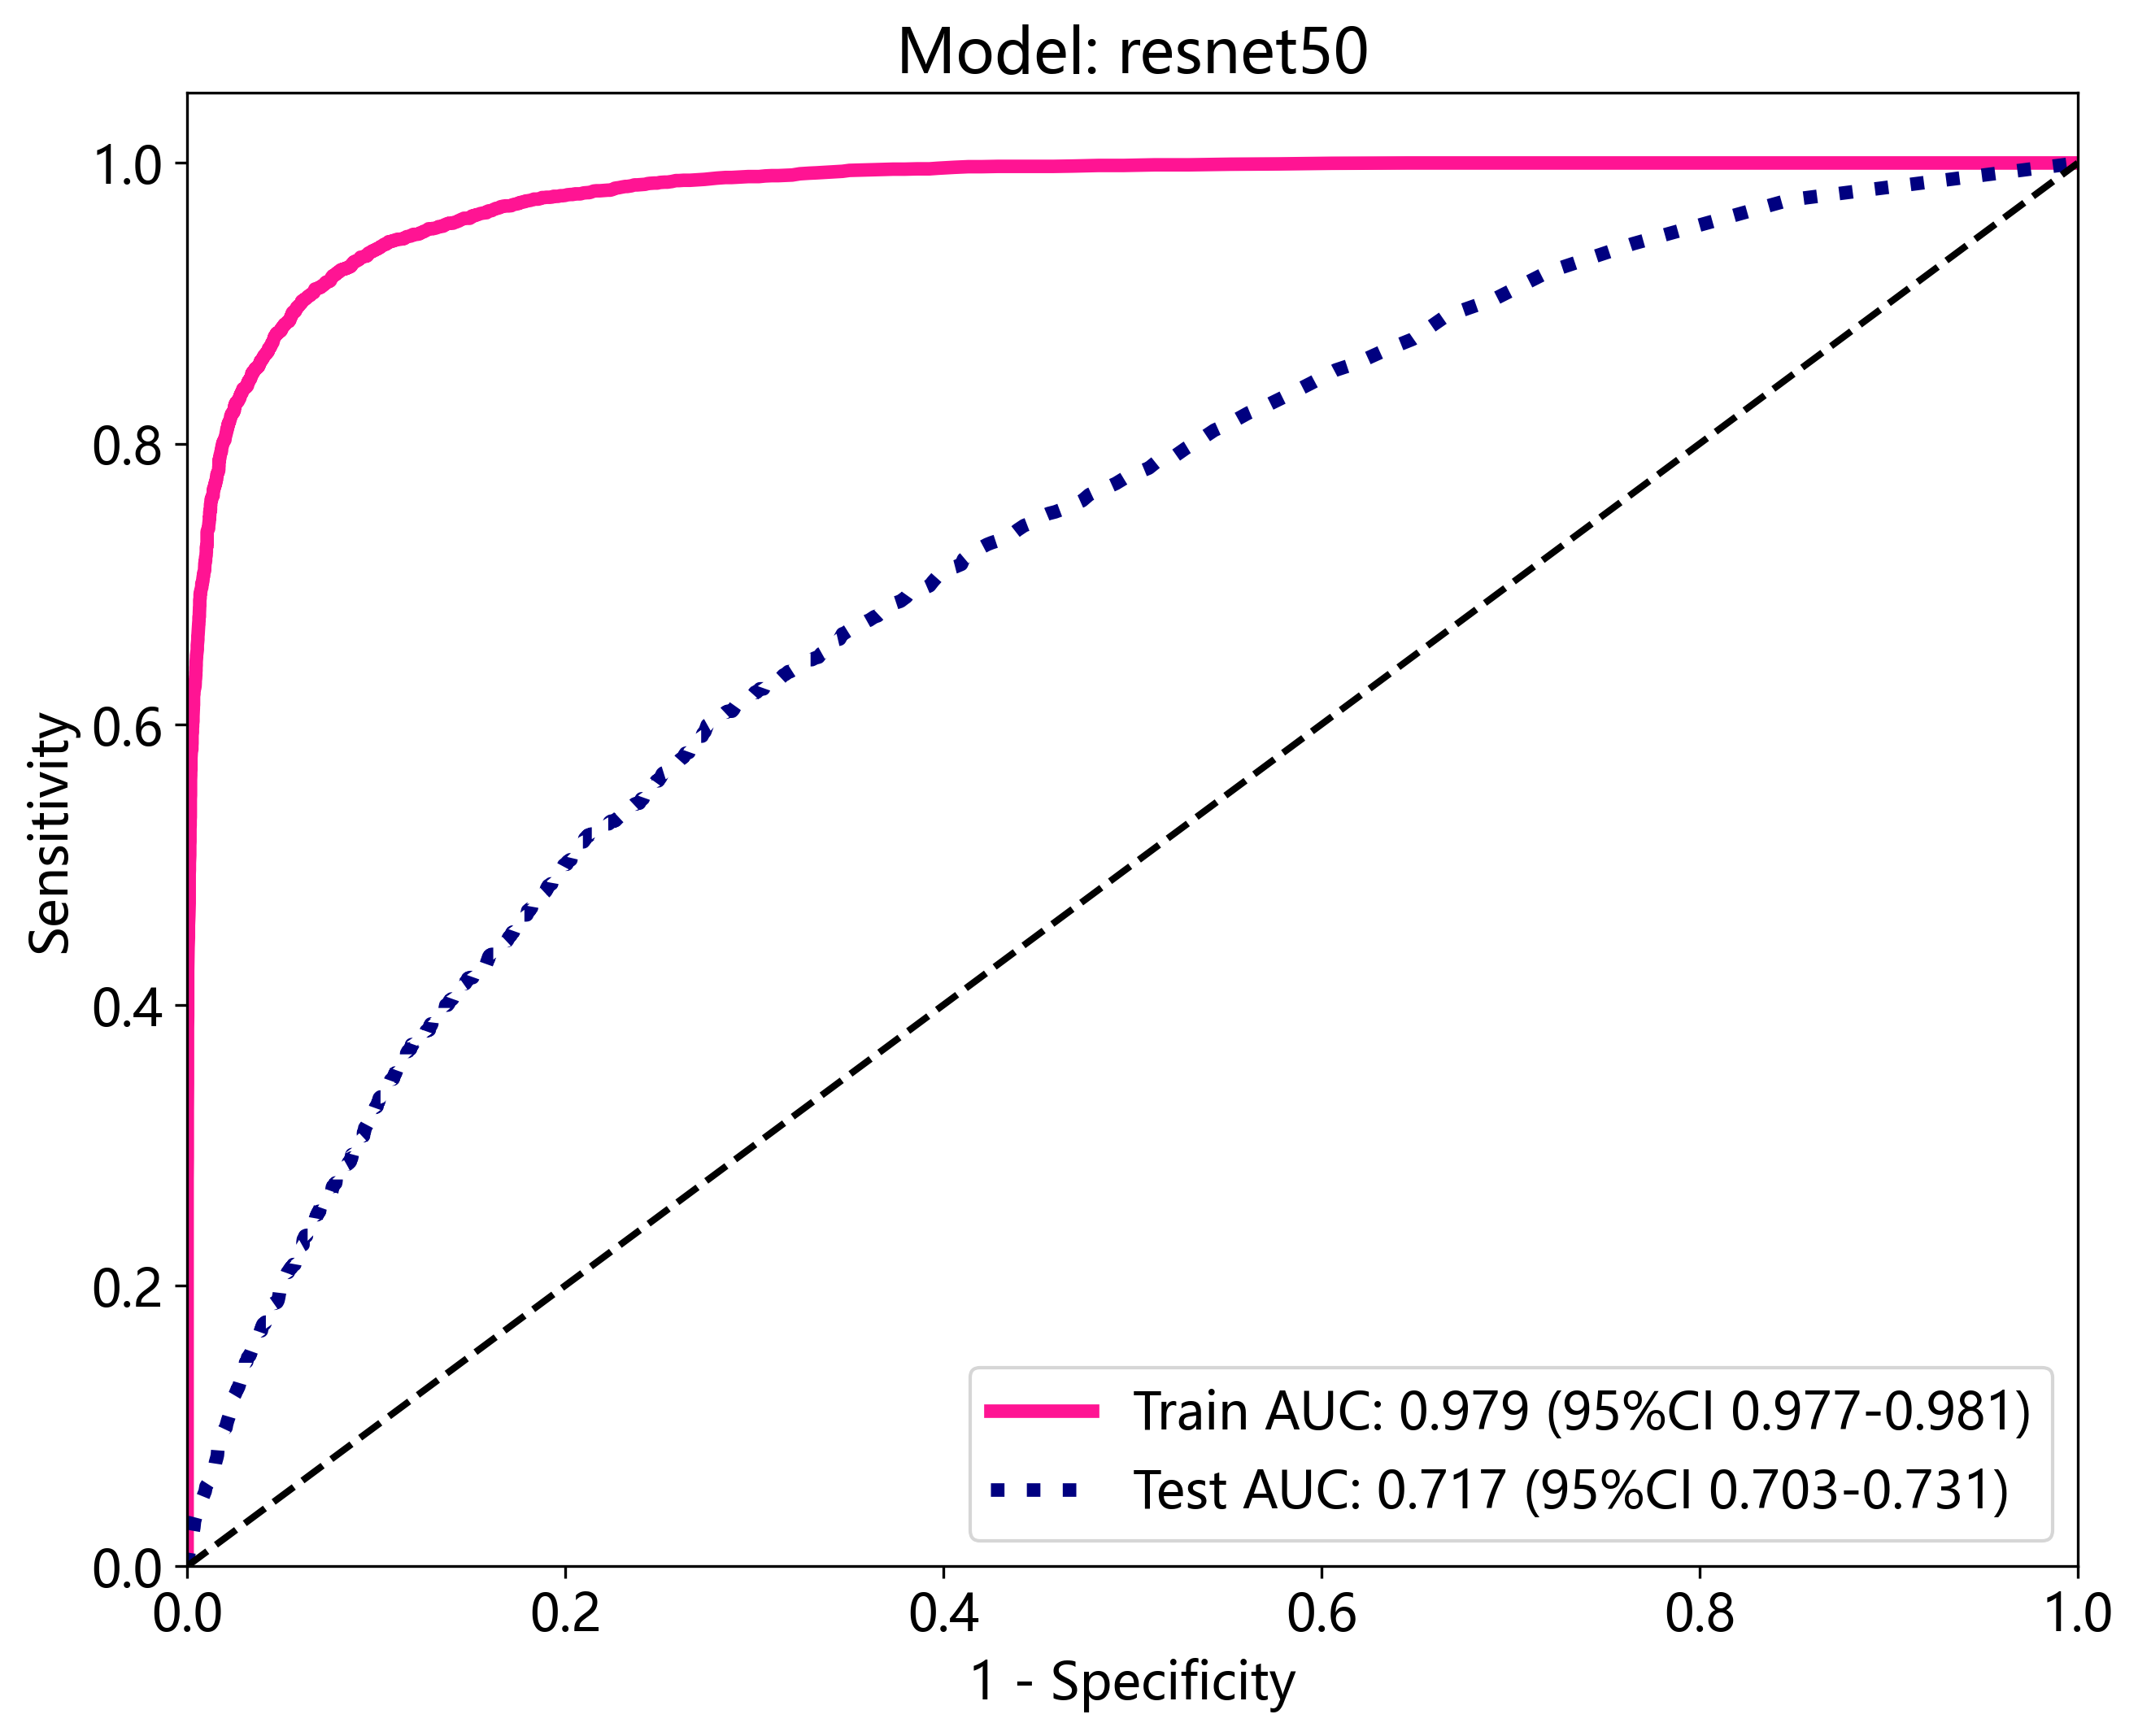

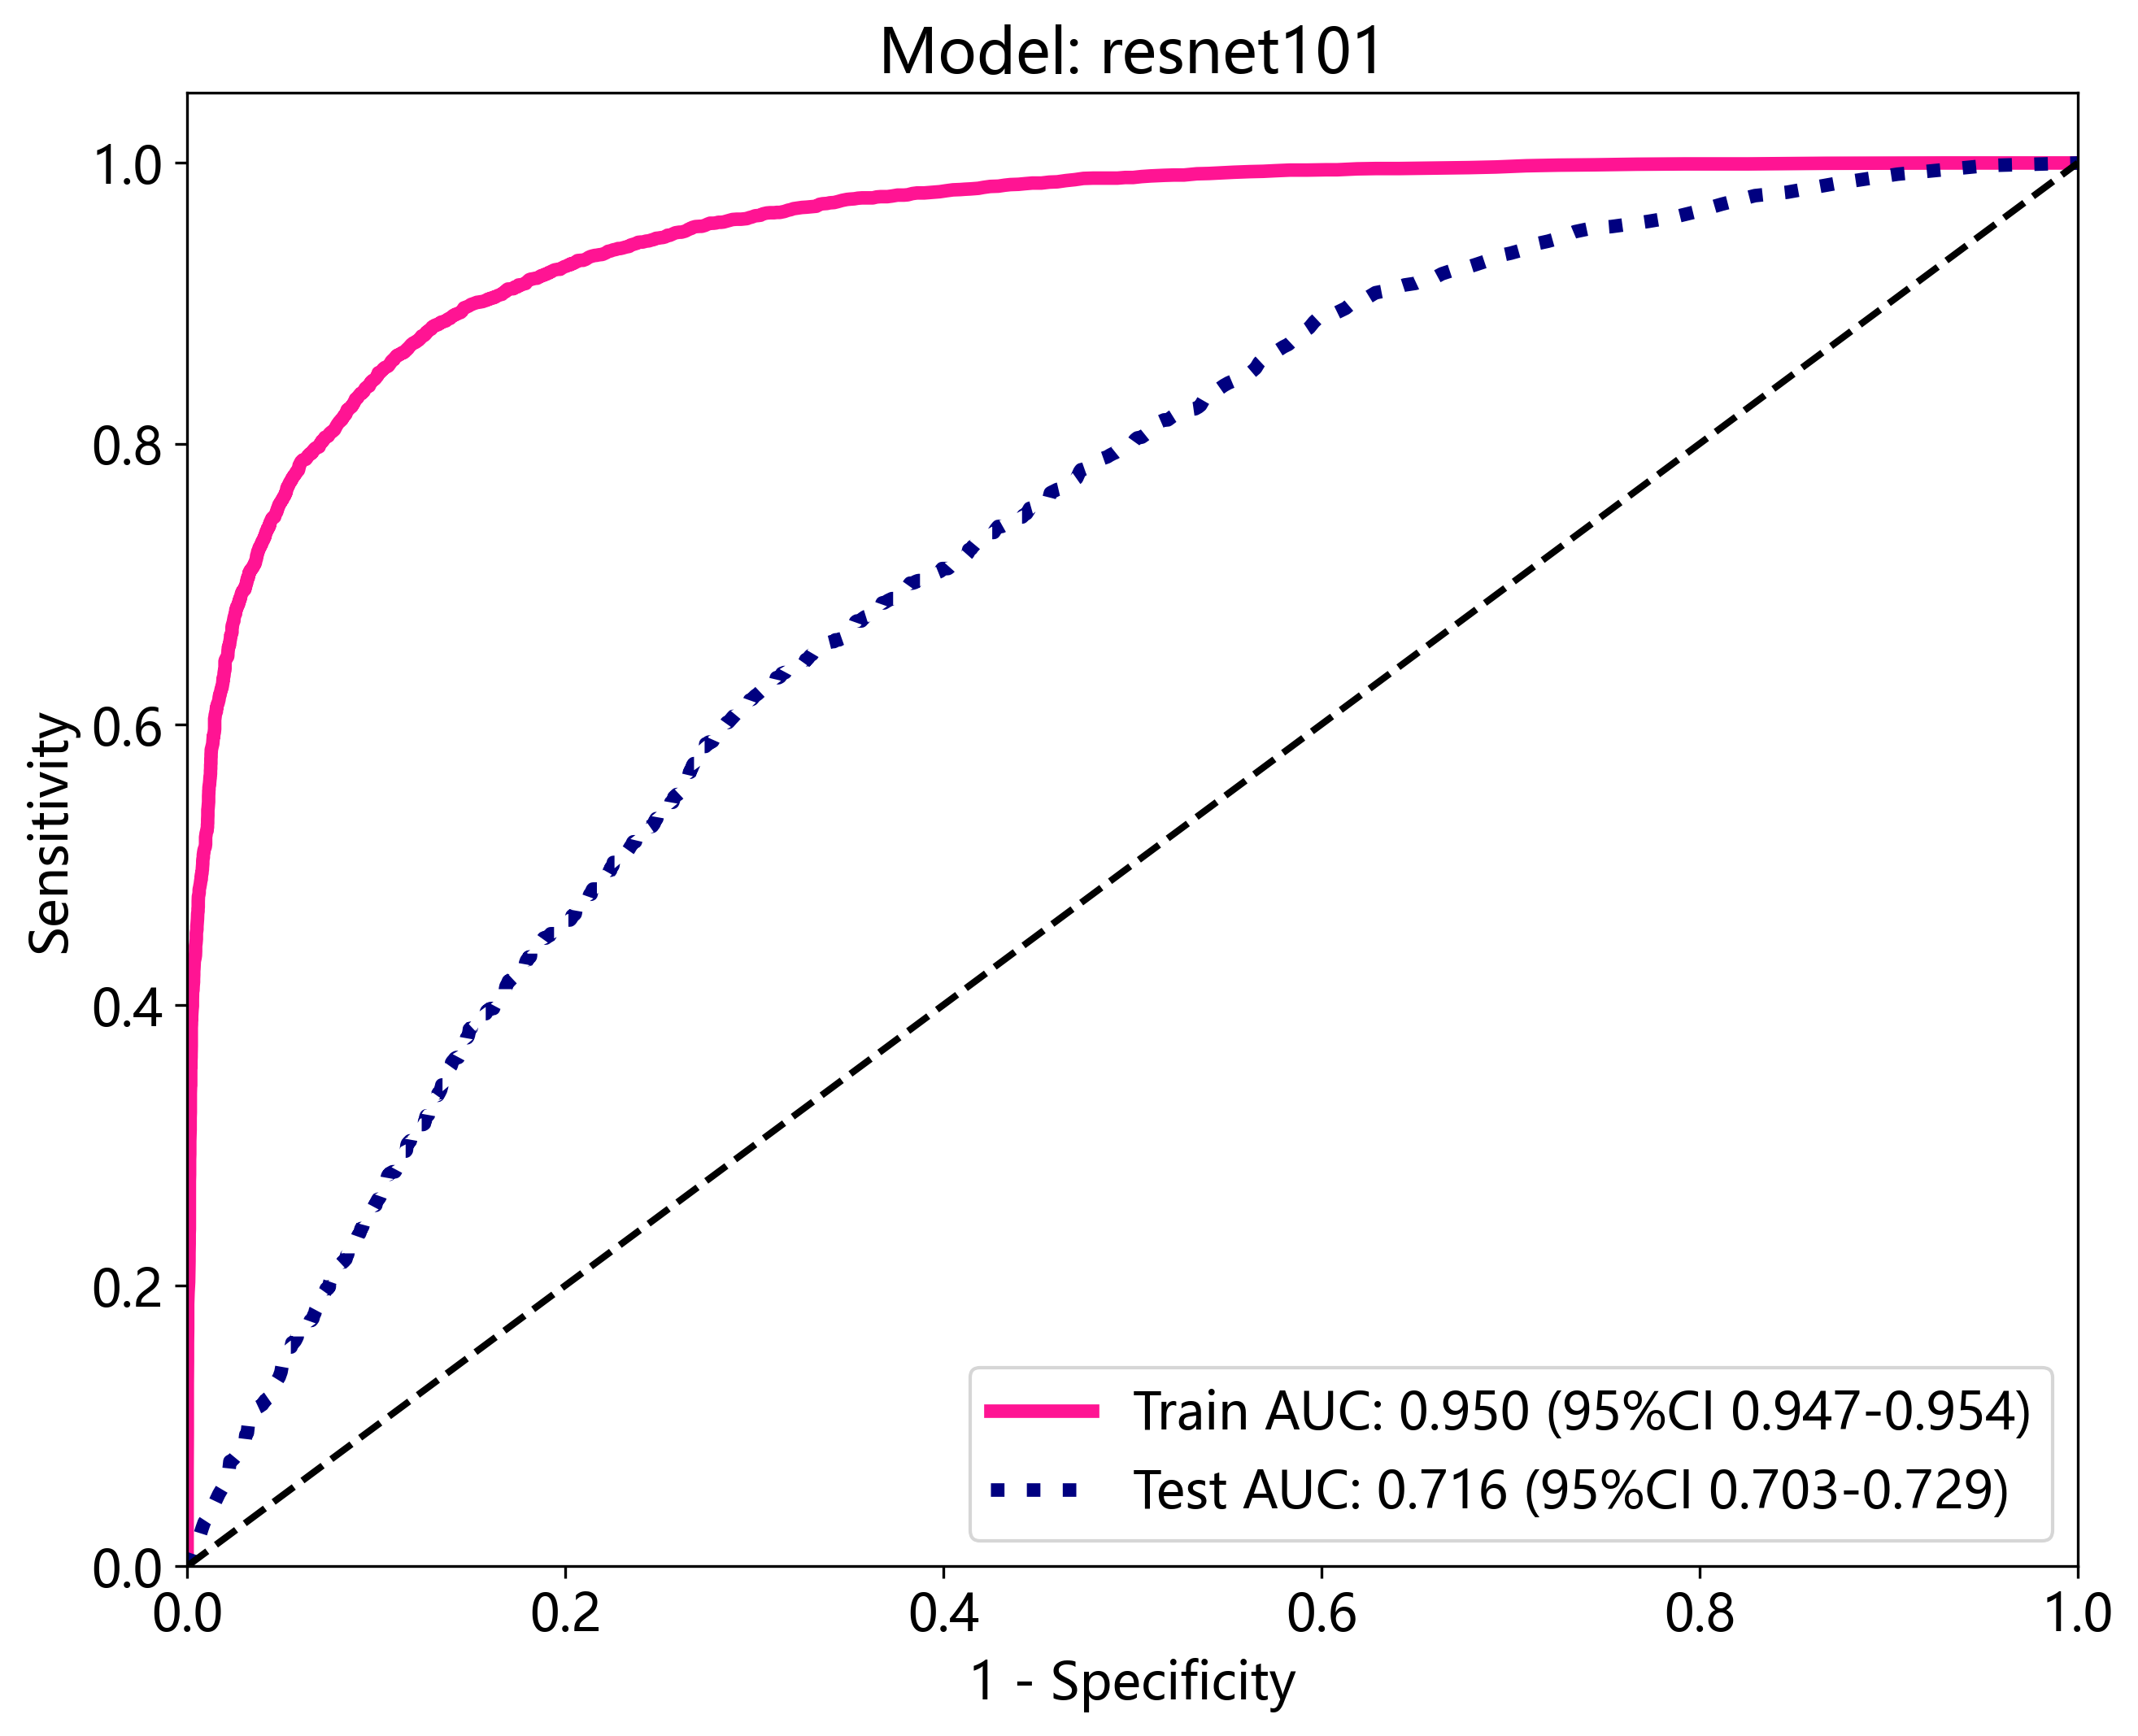

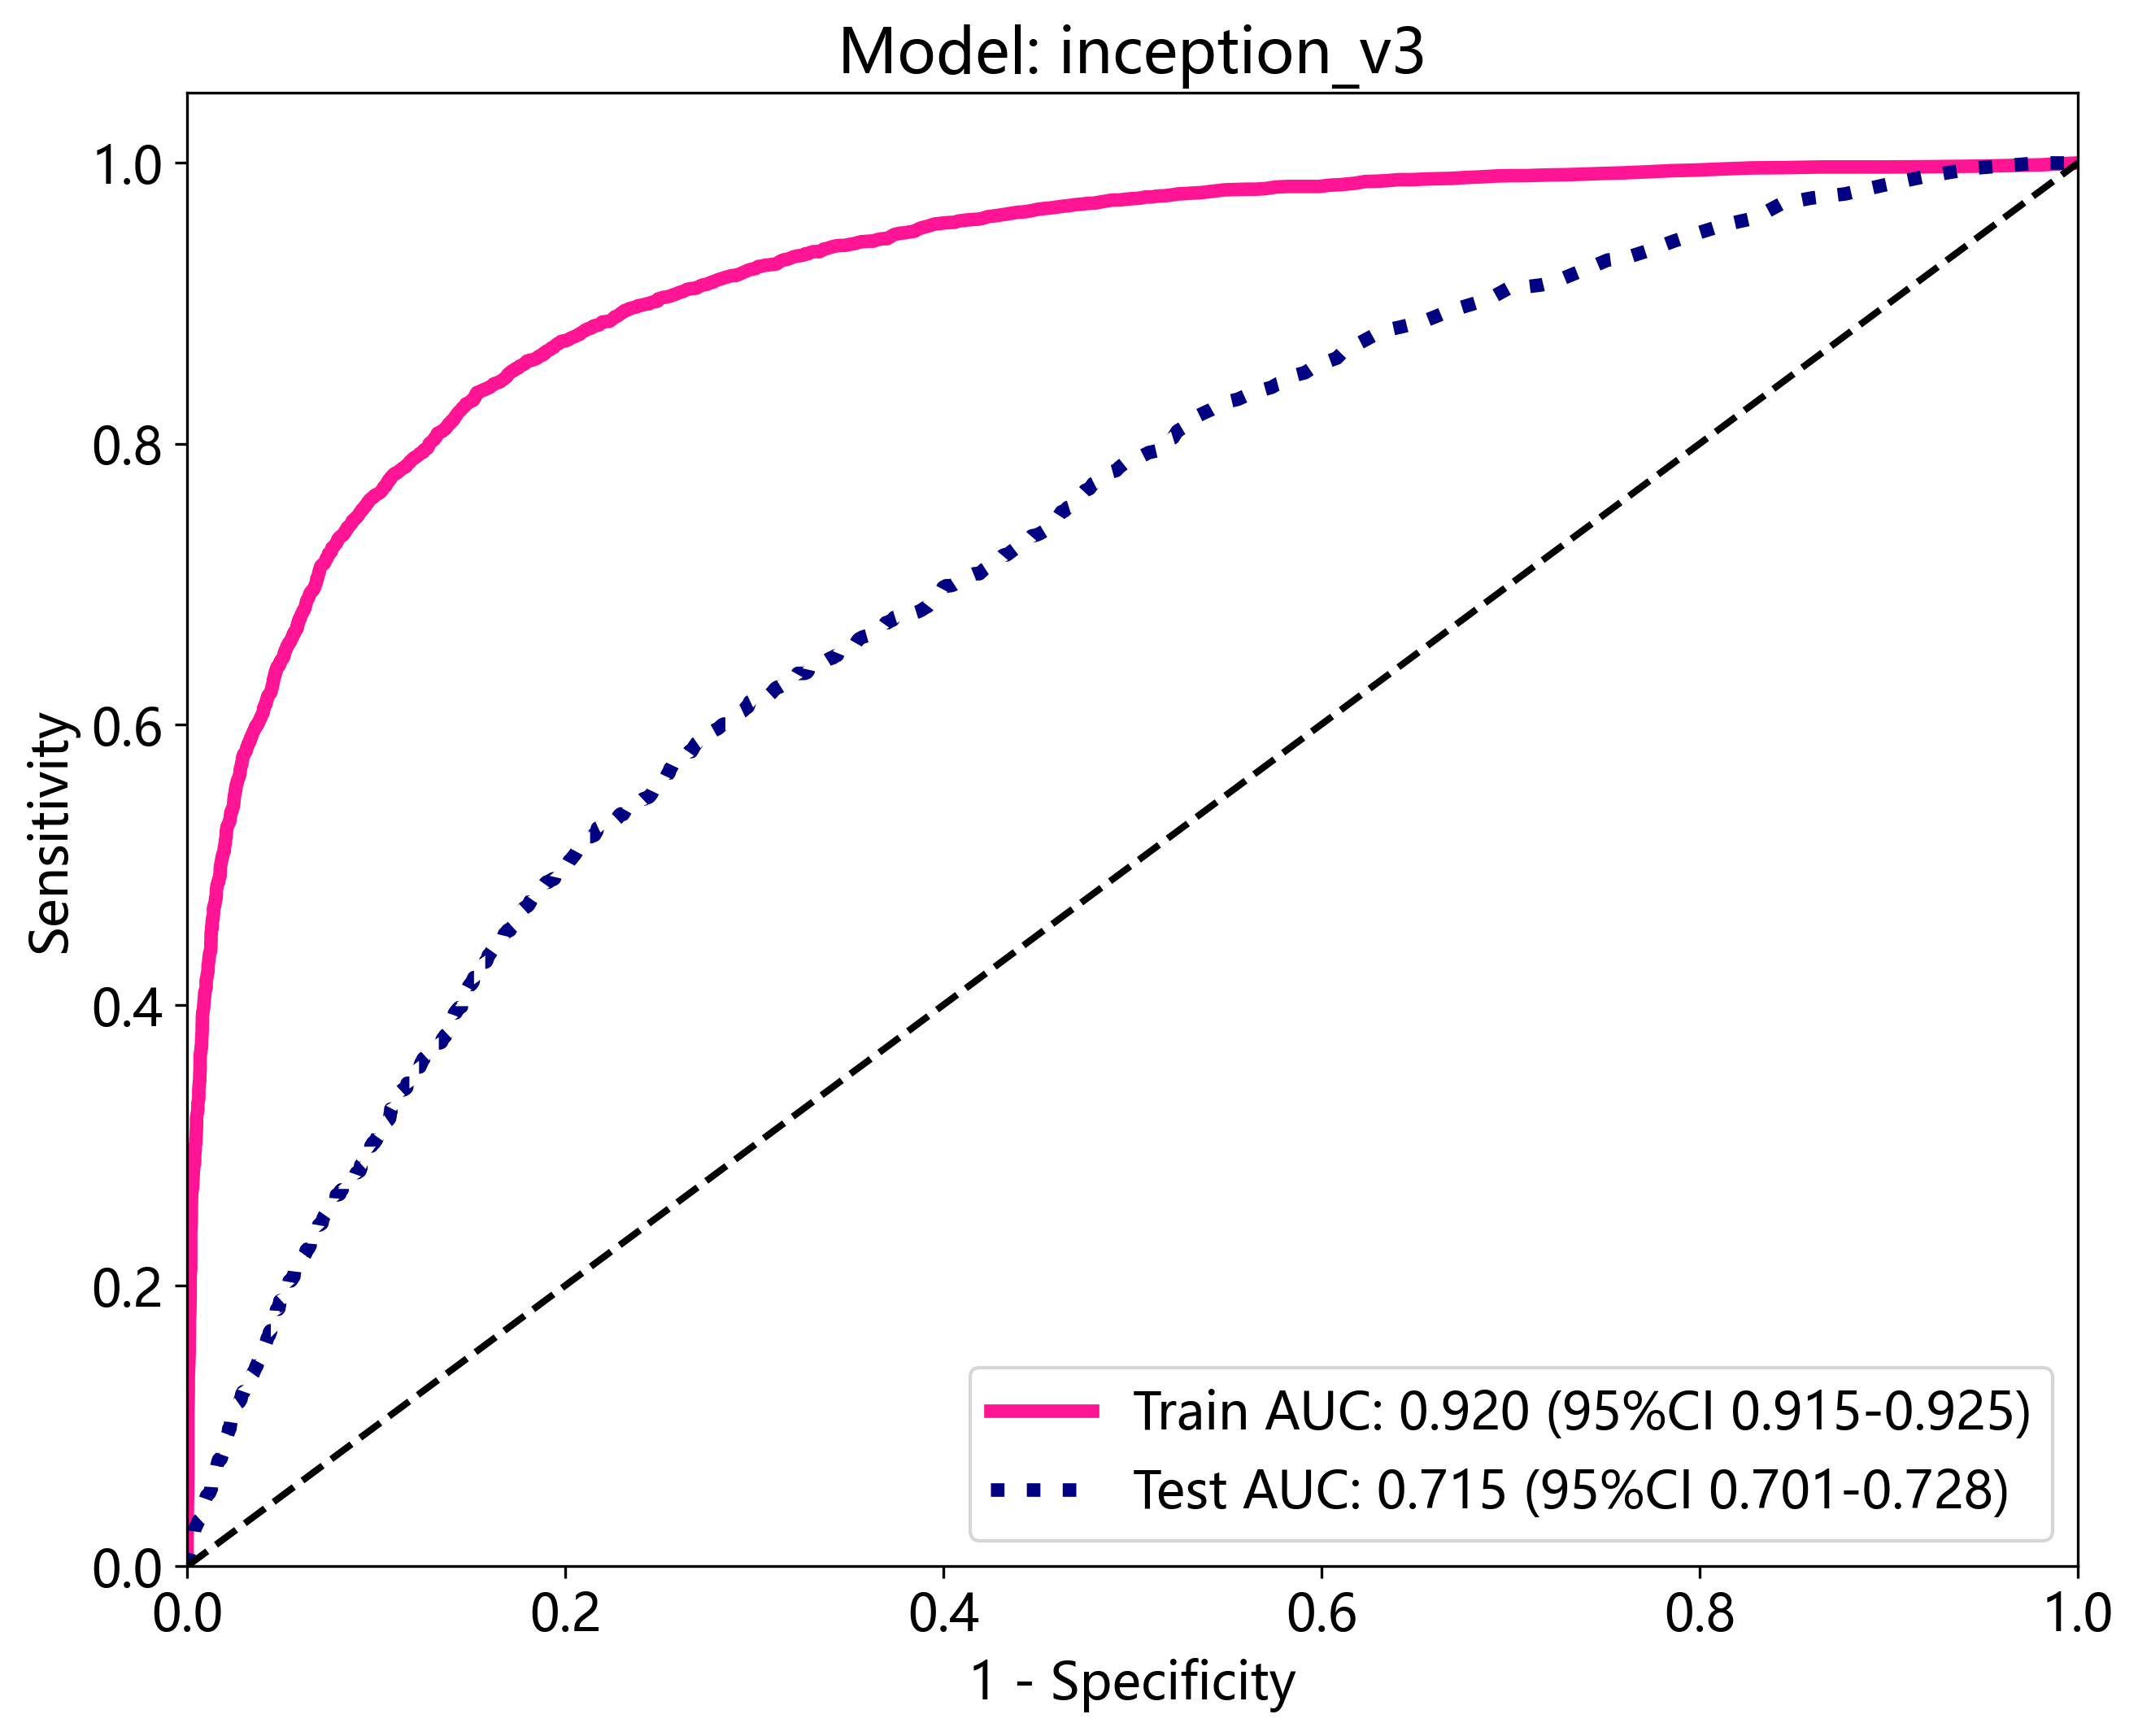

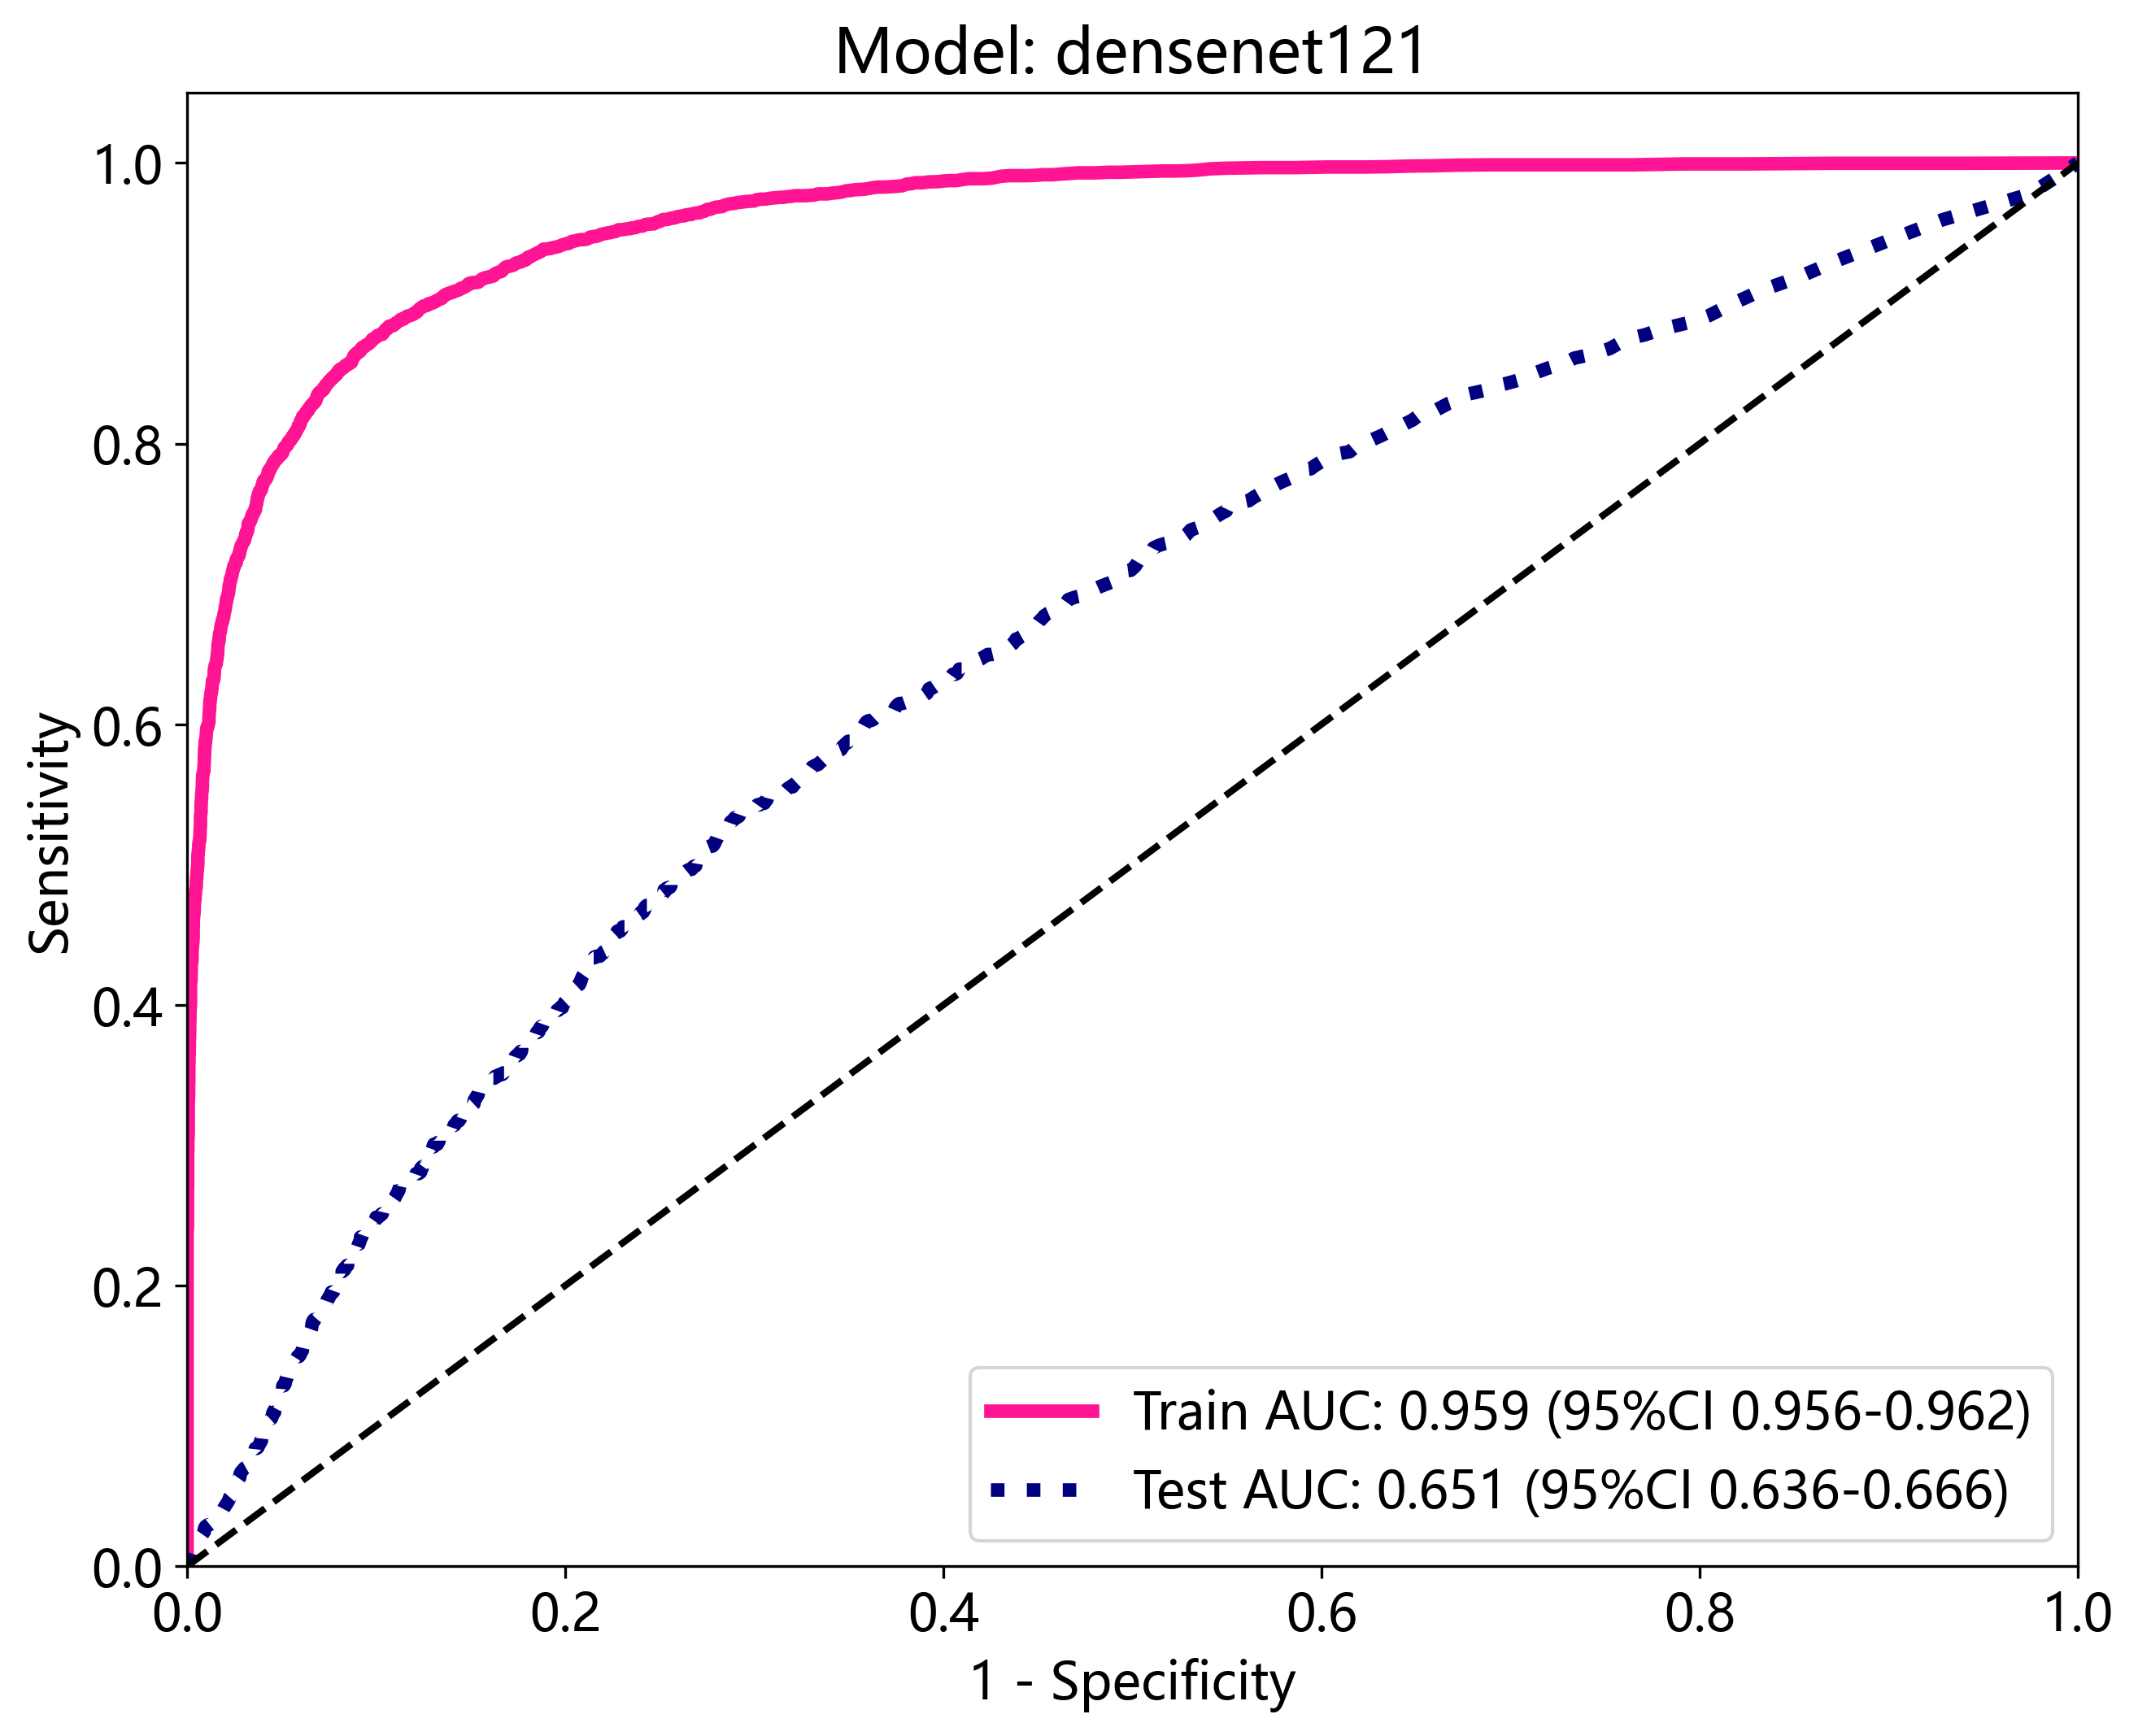

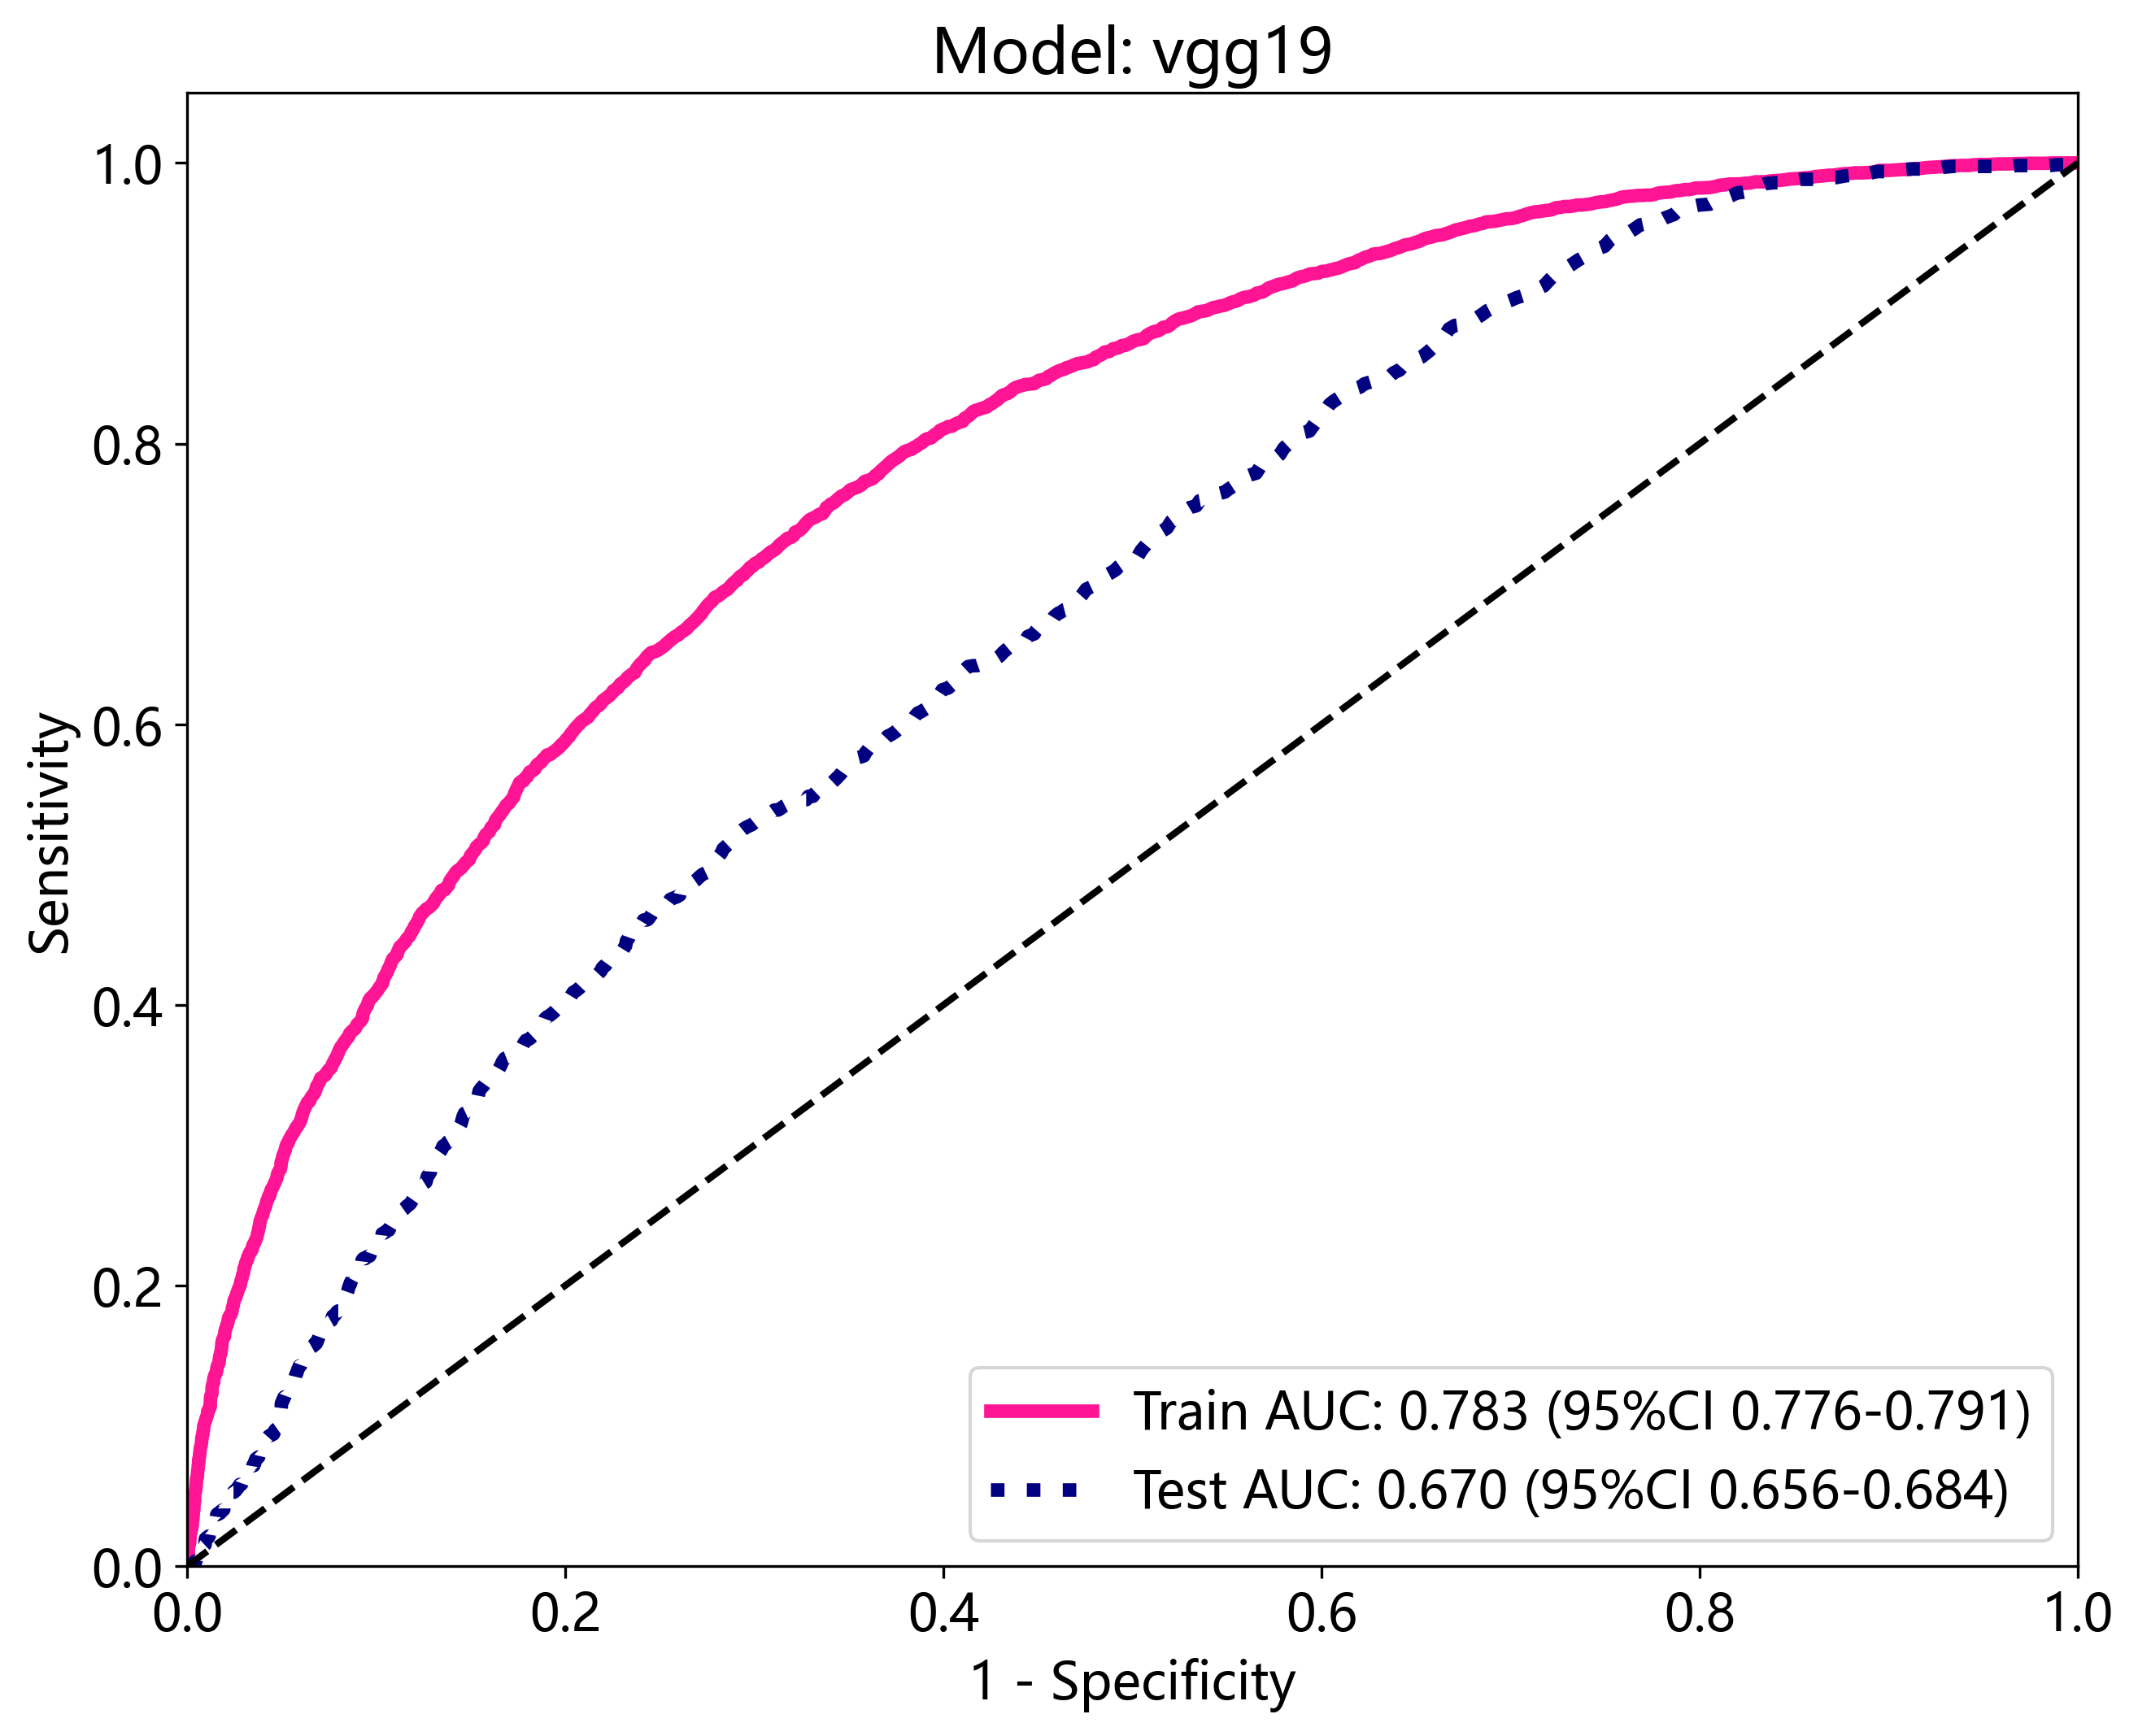

,ModelName,Acc,AUC,95% CI,Sensitivity,Specificity,PPV,NPV,Precision,Recall,F1,Threshold,Cohort
0,resnet18,0.836,0.912,0.9067-0.9166,0.820,0.843,0.703,0.912,0.703,0.820,0.757,0.322,train
1,resnet18,0.635,0.626,0.6111-0.6417,0.528,0.664,0.293,0.842,0.293,0.528,0.377,0.312,test
2,resnet50,0.922,0.979,0.9768-0.9807,0.919,0.923,0.844,0.962,0.844,0.919,0.880,0.321,train
3,resnet50,0.697,0.717,0.7029-0.7306,0.602,0.722,0.364,0.873,0.364,0.602,0.453,0.144,test
4,resnet101,0.874,0.950,0.9470-0.9538,0.883,0.871,0.756,0.942,0.756,0.883,0.814,0.293,train
5,resnet101,0.675,0.716,0.7029-0.7291,0.635,0.686,0.348,0.877,0.348,0.635,0.450,0.271,test
6,inception_v3,0.843,0.920,0.9153-0.9248,0.835,0.847,0.712,0.919,0.712,0.835,0.769,0.304,train
7,inception_v3,0.684,0.715,0.7008-0.7284,0.612,0.703,0.353,0.873,0.353,0.612,0.448,0.204,test
8,densenet121,0.890,0.959,0.9560-0.9621,0.883,0.893,0.790,0.944,0.790,0.883,0.834,0.323,train
9,densenet121,0.671,0.651,0.6358-0.6663,0.538,0.707,0.326,0.853,0.326,0.538,0.406,0.246,test


In [2]:
import pandas as pd
import os
from onekey_algo.custom.components.ugly import drop_error
import numpy as np
from onekey_algo.custom.components import metrics
from onekey_algo.custom.components.comp1 import draw_roc
import matplotlib.pyplot as plt
from onekey_algo import get_param_in_cwd

os.makedirs('img', exist_ok=True)
metric_results = []
dtl = []

sm = {'inception_v3': 3, 'resnet50': 5, 'TwinsSVT': 24}
model_root = os.path.join(get_param_in_cwd('model_root'), '1')
for epoch in range(1):
    for model in get_param_in_cwd('cnn_models'):
#         if model != 'TwinsSVT':
#             continue
        train_log_path = os.path.join(model_root, rf'{model}/viz/BST_TRAIN_RESULTS.txt')
#         train_log_path = rf'F:\20231108-CaiXinJia\models/{model}/train/Epoch-{sm[model]}.txt'
        train_log = pd.read_csv(train_log_path, names=['fname', 'pred_score', 'pred_label', 'gt'], sep='\t')
        train_log['group'] = 'train'
        val_log_path = os.path.join(model_root, rf'{model}/viz/BST_VAL_RESULTS.txt')
#         val_log_path = rf'F:\20231108-CaiXinJia\models/{model}/valid/Epoch-{sm[model]}.txt'
        val_log = pd.read_csv(val_log_path, names=['fname', 'pred_score', 'pred_label', 'gt'], sep='\t')
        val_log['group'] = 'test'
        log = pd.concat([train_log, val_log], axis=0)
        log['ID'] = log['fname'].map(lambda x: os.path.basename(x).split('_')[0])
#         log = pd.merge(log, group[['ID']], on='ID', how='inner')
        all_pred = []
        all_gt = []
    #     log = pd.merge(log, data, left_on='fname', right_on='fpath', how='inner')
        for subset in ['train', 'test']:
            val_log = log[log['group'] == subset]
            # ----
    #         if subset in ['val', 'test1', 'test2']:
    #             sel_idx, = drop_error([val_log['pred_label']], [val_log['gt']], [val_log['pred_score']], ratio=ra[subset])
    #             print(model, subset, val_log.shape, val_log[sel_idx].shape)
    #             val_log = val_log[sel_idx]
    #         # ----
    #         display(val_log)
            ul_labels = np.unique(val_log['pred_label'])
            pred_score = list(map(lambda x: x[0] if x[1] == 1 else 1-x[0], np.array(val_log[['pred_score', 'pred_label']])))
            gt = [1 if gt_ == 1 else 0 for gt_ in np.array(val_log['gt'])]
    #         print(len(pred_score))
            acc, auc, ci, tpr, tnr, ppv, npv, precision, recall, f1, thres = metrics.analysis_pred_binary(gt, pred_score, 
                                                                                                          use_youden=True)
            ci = f"{ci[0]:.4f}-{ci[1]:.4f}"
            metric_results.append([model, acc, auc, ci, tpr, tnr, ppv, npv, precision, recall, f1, thres, subset])

            all_pred.append(np.array(list(map(lambda x: (1-x[0], x[0]) if x[1] == 1 else (x[0], 1-x[0]), 
                                              np.array(val_log[['pred_score', 'pred_label']])))))
            all_gt.append(gt)

        draw_roc(all_gt, all_pred, labels=['Train', 'Test'], title=f"Model: {model}")
        plt.savefig(f'img/DL_model_{model}_roc.svg', bbox_inches = 'tight')
        plt.show()
metrics = pd.DataFrame(metric_results, 
             columns=['ModelName', 'Acc', 'AUC', '95% CI', 'Sensitivity', 'Specificity', 'PPV', 'NPV', 
                      'Precision', 'Recall', 'F1', 'Threshold', 'Cohort'])
metrics

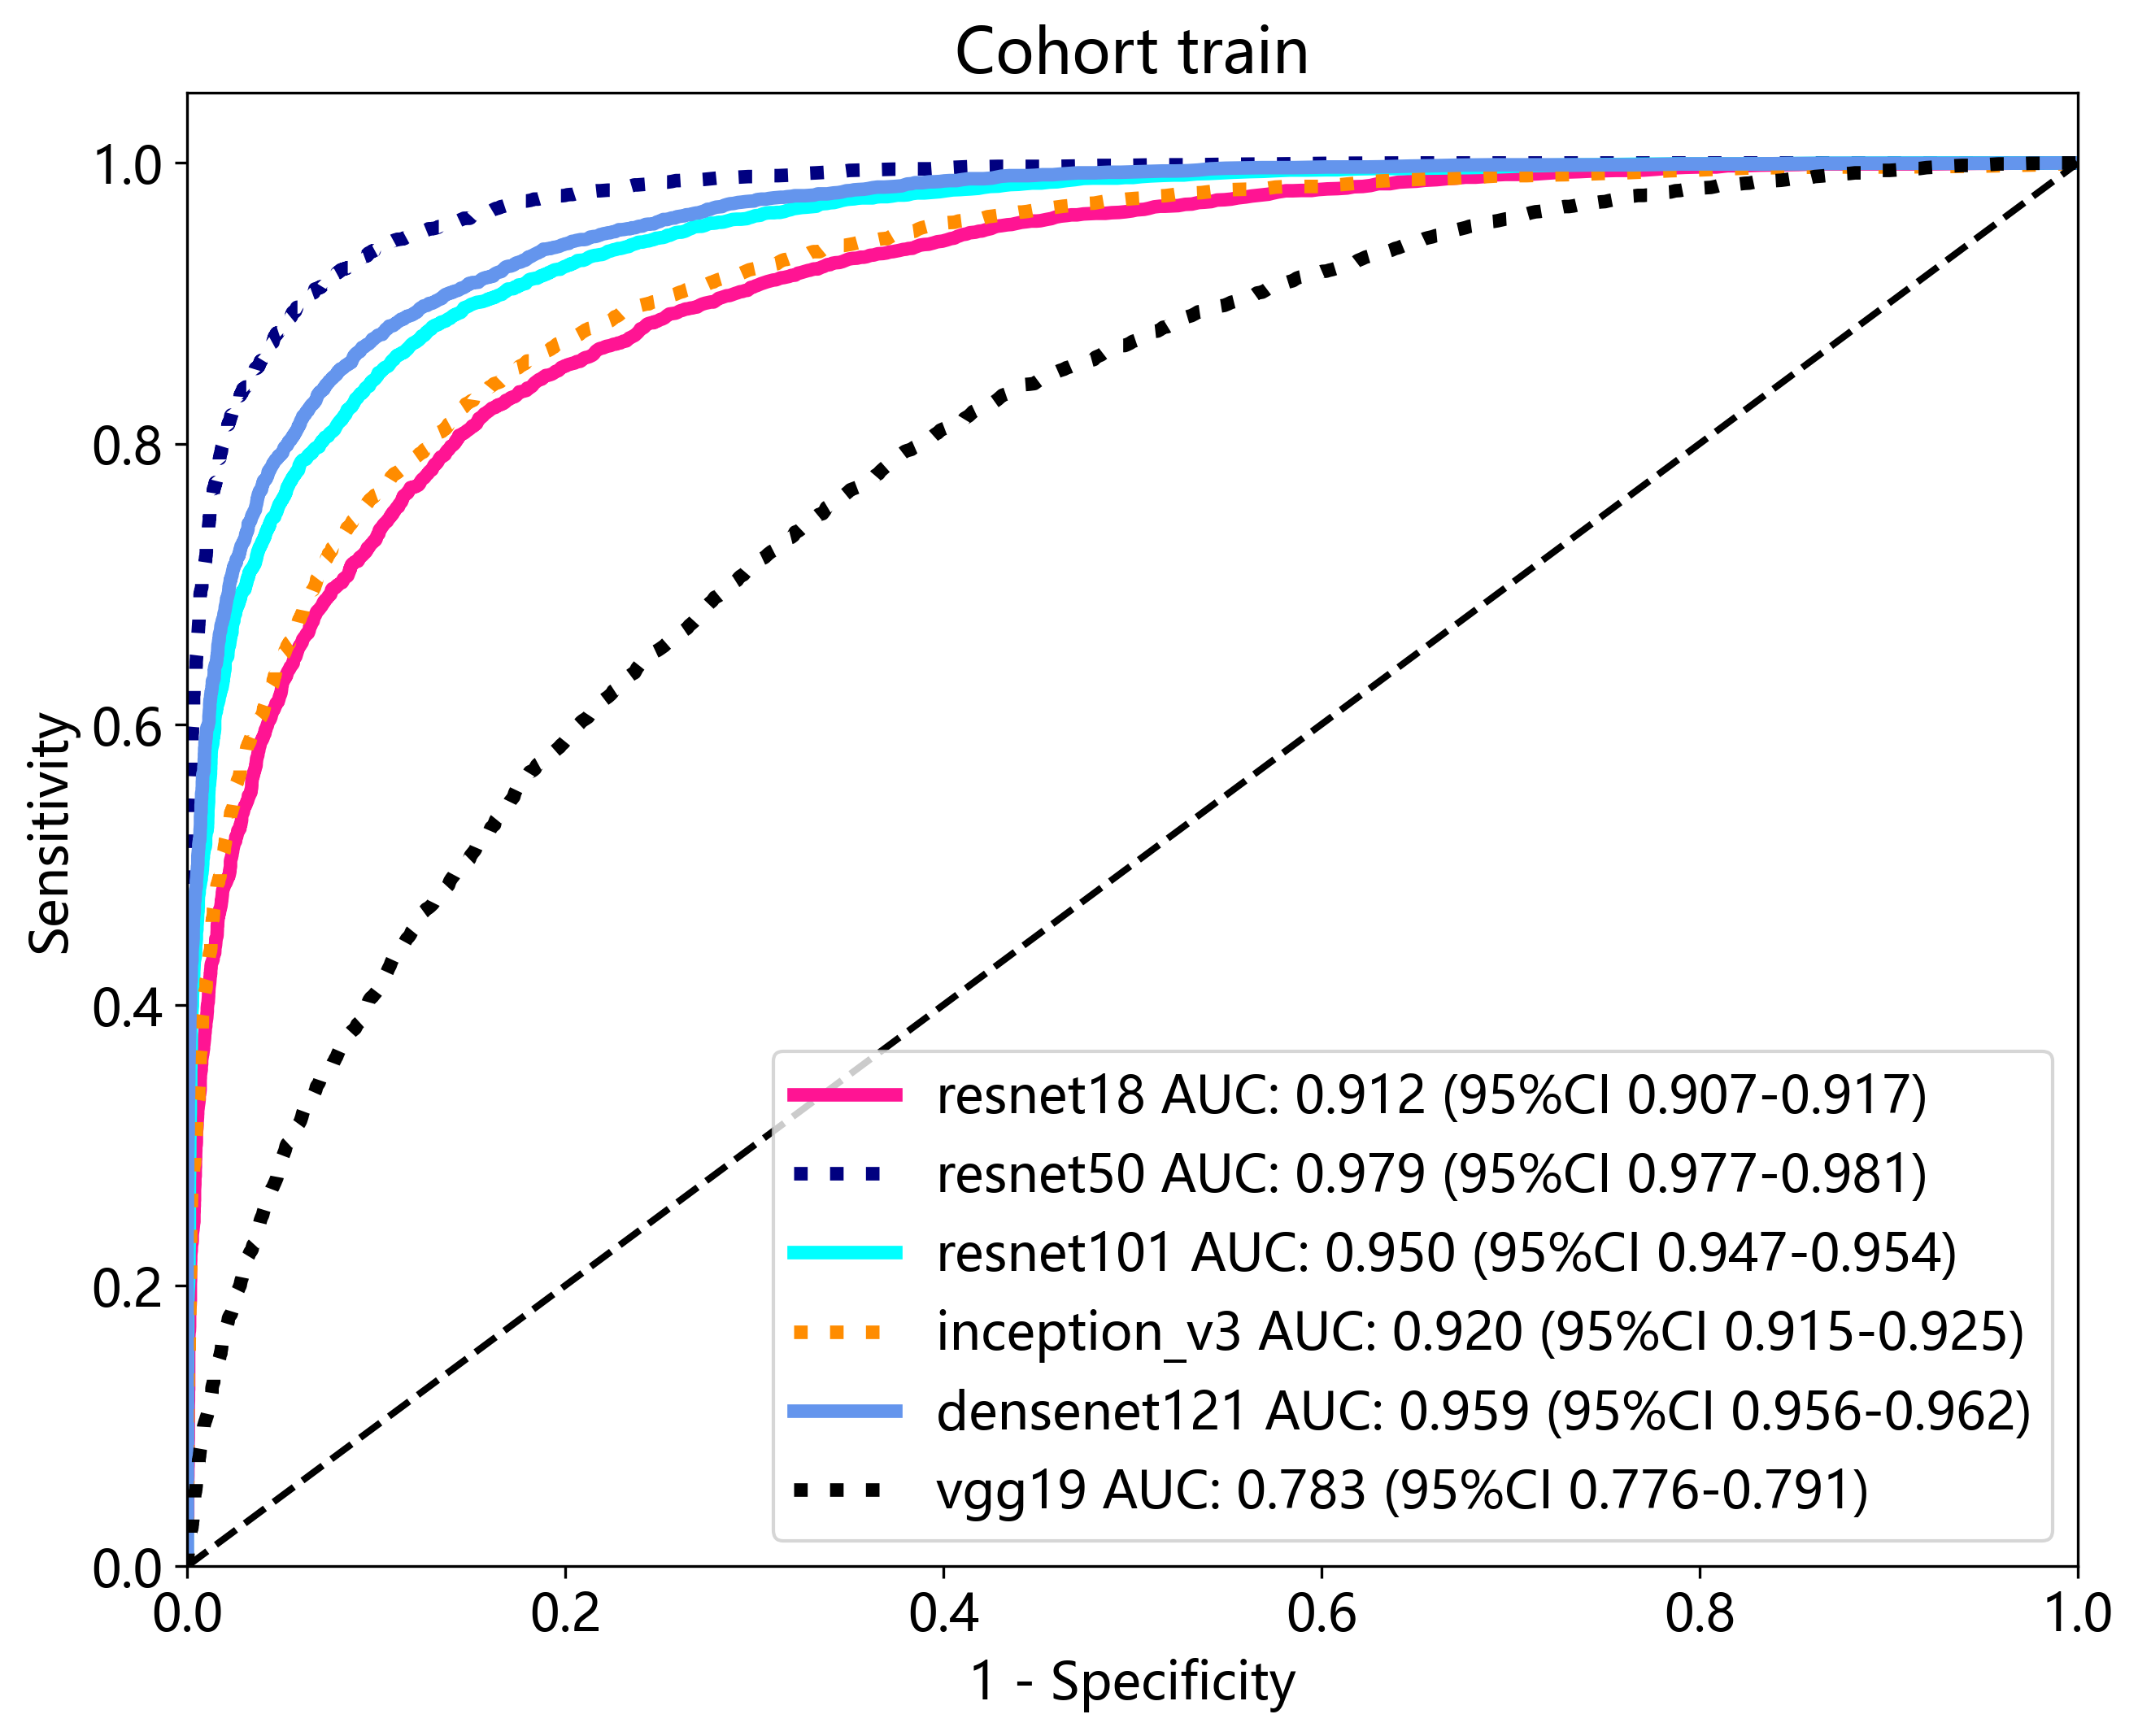

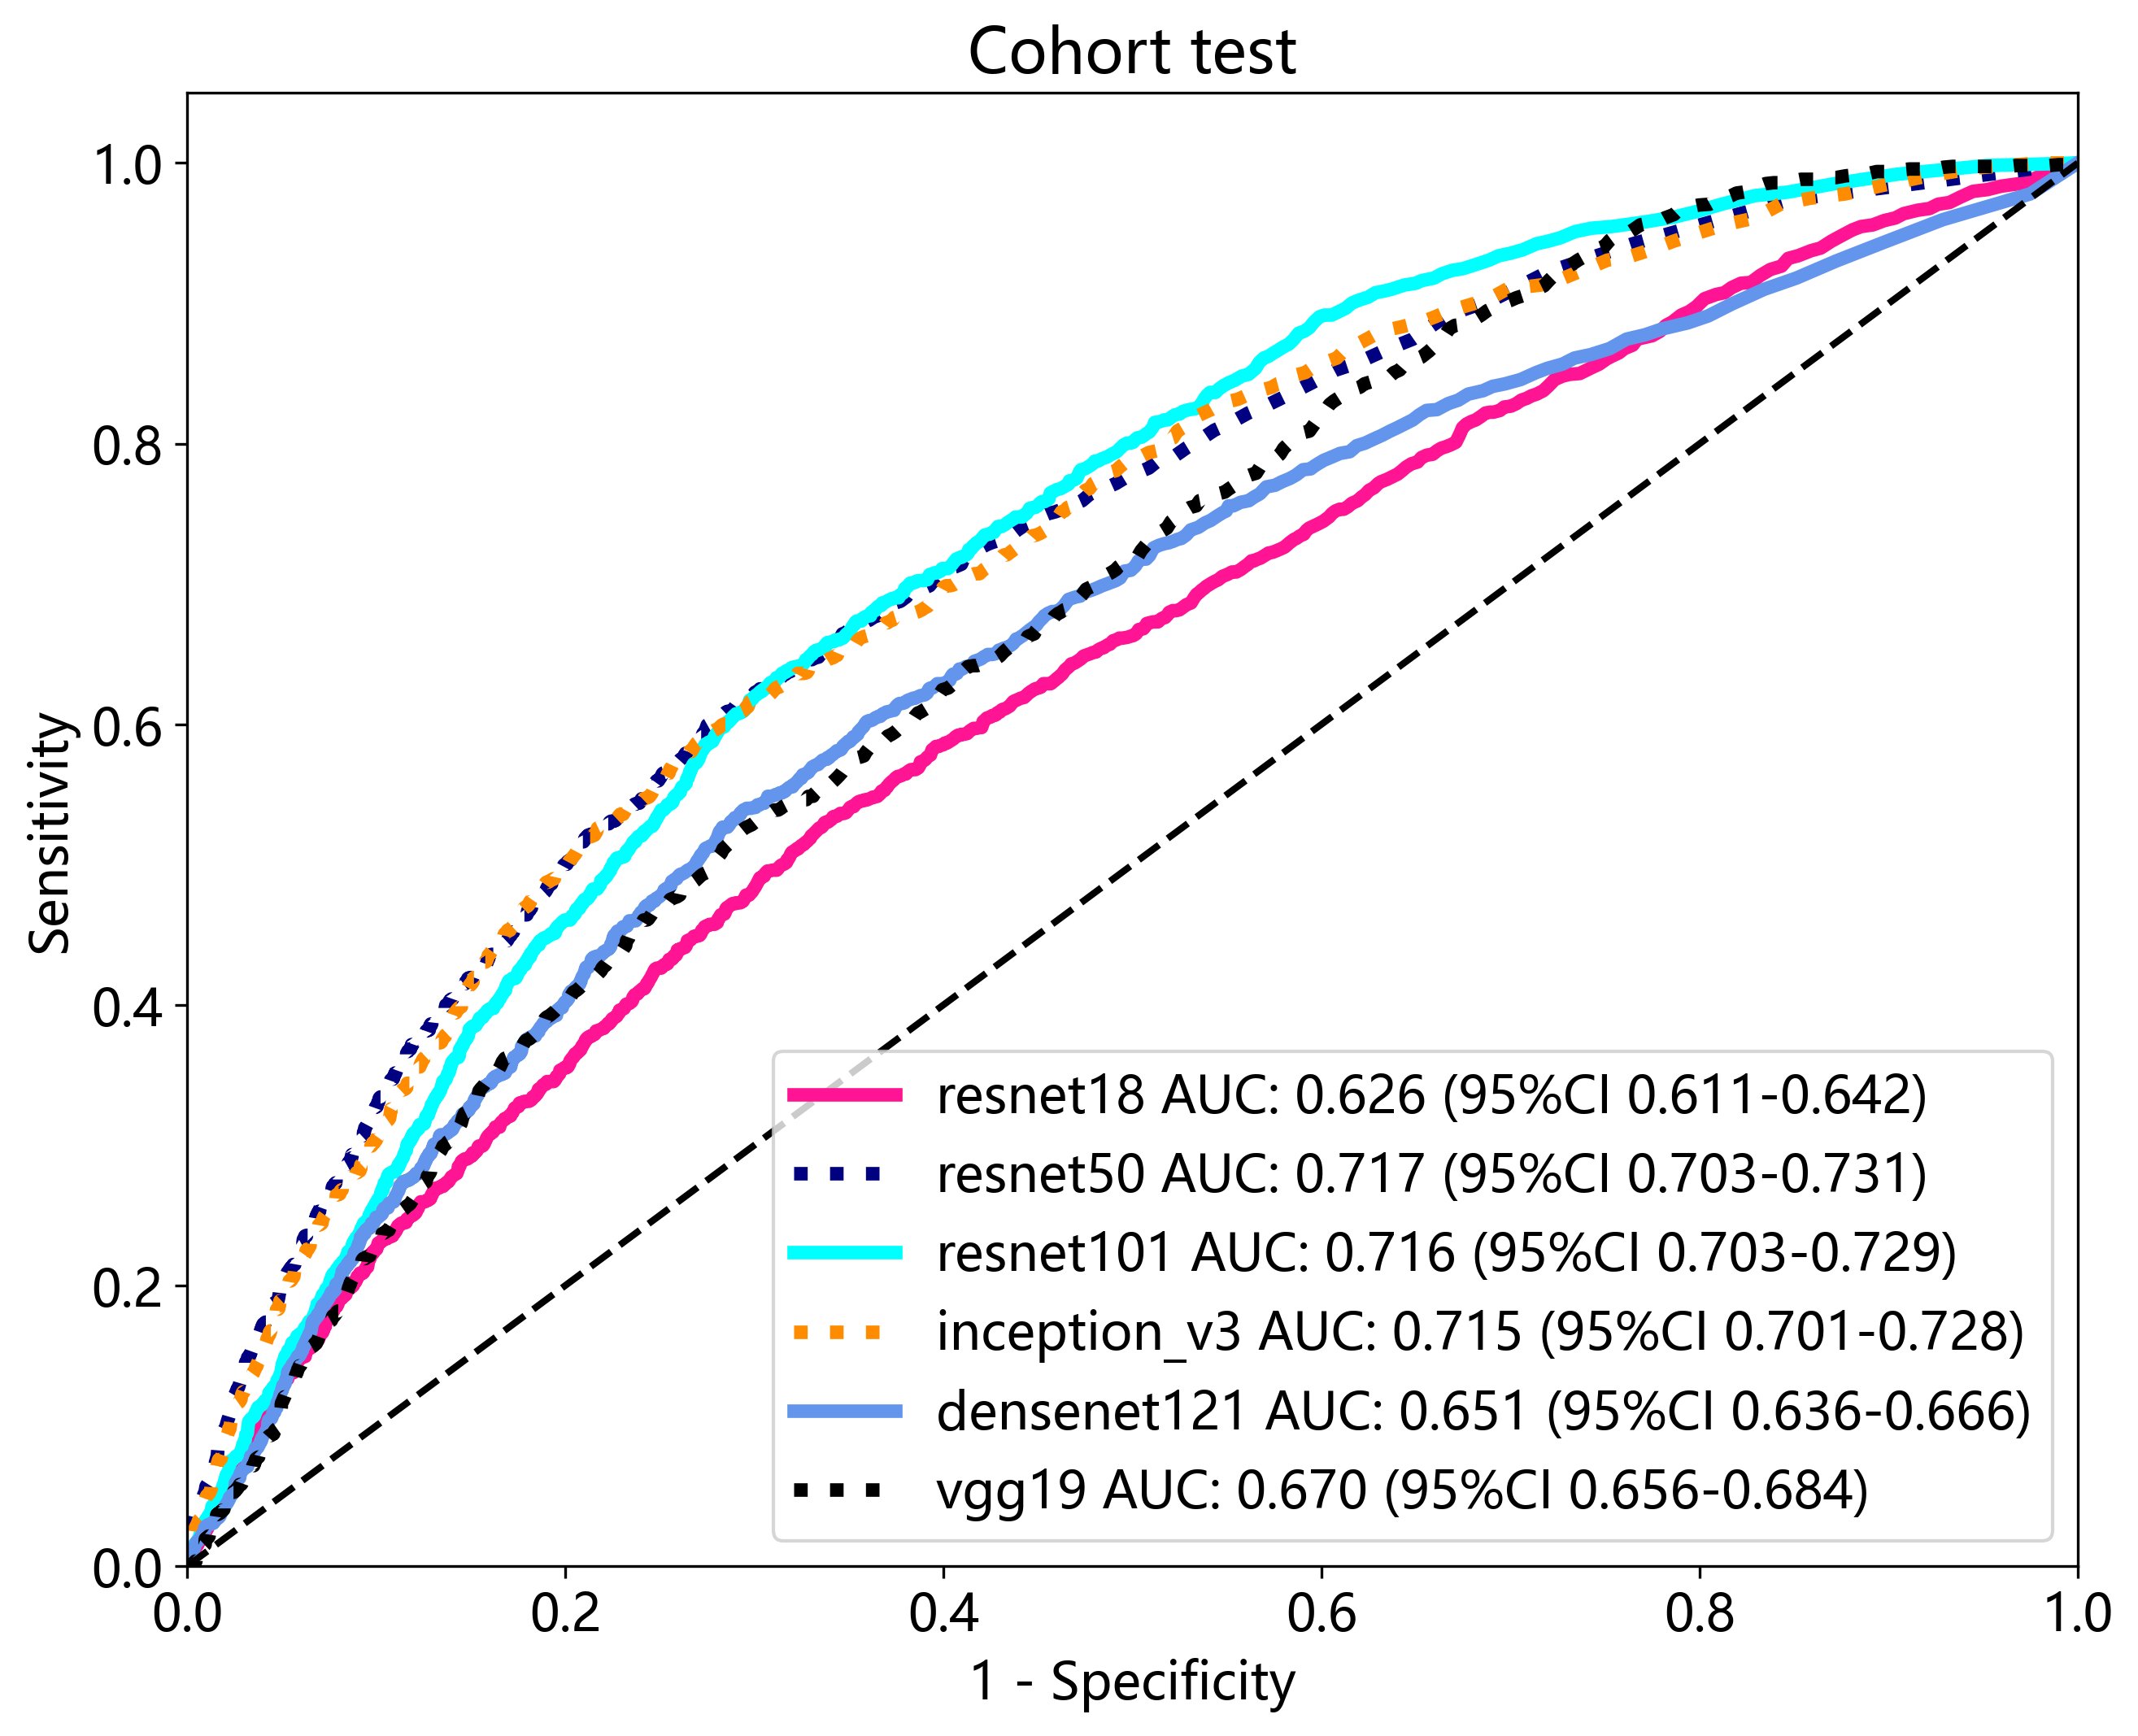

In [3]:
import pandas as pd
import os
from onekey_algo.custom.components.ugly import drop_error
import numpy as np
from onekey_algo.custom.components import metrics
from onekey_algo.custom.components.comp1 import draw_roc
import matplotlib.pyplot as plt
from onekey_algo import get_param_in_cwd

os.makedirs('img', exist_ok=True)
metric_results = []
dtl = []

sm = {'inception_v3': 3, 'resnet50': 5, 'TwinsSVT': 24}
# model_root = get_param_in_cwd('model_root')
for epoch in range(1):
    for subset in ['train', 'test']:
        all_pred = []
        all_gt = []
        for model in get_param_in_cwd('cnn_models'):
            train_log_path = os.path.join(model_root, rf'{model}/viz/BST_TRAIN_RESULTS.txt')
    #         train_log_path = rf'F:\20231108-CaiXinJia\models/{model}/train/Epoch-{sm[model]}.txt'
            train_log = pd.read_csv(train_log_path, names=['fname', 'pred_score', 'pred_label', 'gt'], sep='\t')
            train_log['group'] = 'train'
            val_log_path = os.path.join(model_root, rf'{model}/viz/BST_VAL_RESULTS.txt')
    #         val_log_path = rf'F:\20231108-CaiXinJia\models/{model}/valid/Epoch-{sm[model]}.txt'
            val_log = pd.read_csv(val_log_path, names=['fname', 'pred_score', 'pred_label', 'gt'], sep='\t')
            val_log['group'] = 'test'
            log = pd.concat([train_log, val_log], axis=0)
            log['ID'] = log['fname'].map(lambda x: os.path.basename(x).split('_')[0])
#             log = pd.merge(log, group[['ID']], on='ID', how='inner')
            
            val_log = log[log['group'] == subset]
            ul_labels = np.unique(val_log['pred_label'])
            pred_score = list(map(lambda x: x[0] if x[1] == 1 else 1-x[0], np.array(val_log[['pred_score', 'pred_label']])))
            gt = [1 if gt_ == 1 else 0 for gt_ in np.array(val_log['gt'])]
            all_pred.append(np.array(list(map(lambda x: (1-x[0], x[0]) if x[1] == 1 else (x[0], 1-x[0]), 
                                              np.array(val_log[['pred_score', 'pred_label']])))))
            all_gt.append(gt)

        draw_roc(all_gt, all_pred, labels=get_param_in_cwd('cnn_models'), title=f"Cohort {subset}")
        plt.savefig(f'img/DL_model_{subset}_roc.svg', bbox_inches = 'tight')
        plt.show()